# (KAGGLE) Partial Least Squares (PLS) Regression Models

In [16]:
########### Libraries ###########
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

########### Paths ###########
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

########### Separar las features del target ###########
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

########### Load preprocessed data (ANKLE data - 2 sessions) ###########
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

########### Train - Test split ###########
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(
                                                df_train = combined_legs_2sessions_A_train, 
                                                df_test = combined_legs_2sessions_A_test)


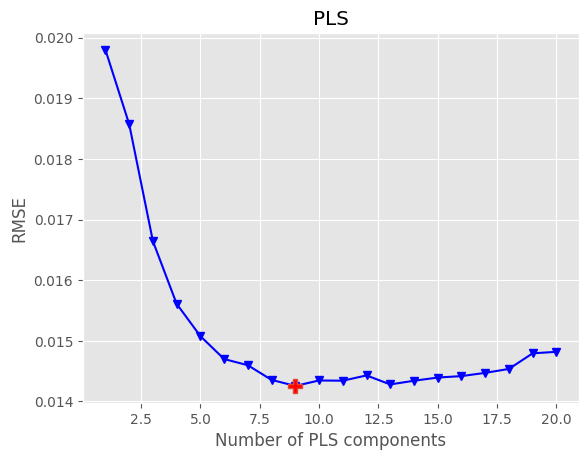

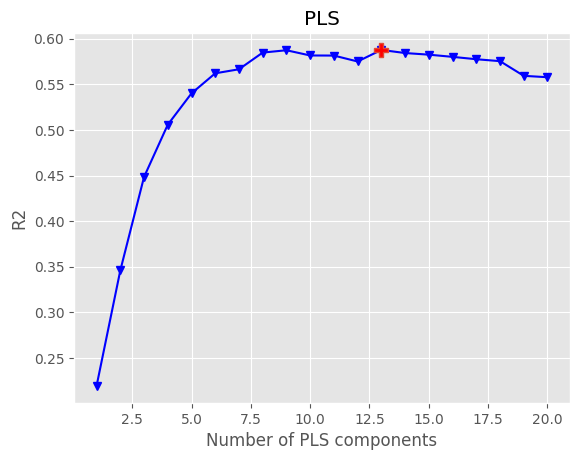

Best number of components (RMSE): 9
Best number of components (R2): 13

R2: 0.587, RMSE: 0.014


In [17]:
########### PLS ########### 
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    rmse = mean_squared_error(y, y_cv, squared=False)
    
    return (y_cv, r2, rmse)

# test with 20 components
r2s = []
rmses = []
ncomp = np.arange(1, 21)
for n_comp in ncomp:
    y_cv, r2, rmse = optimise_pls_cv(X_train_A2, y_train_A2, n_comp)
    r2s.append(r2)
    rmses.append(rmse)

# Plot the rmses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(ncomp, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(ncomp[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = ncomp
        plt.ylabel(ylabel)
        plt.title('PLS')

        # Print the best number of components
        # print(f"Number of components: {idx + 1}")

    plt.show()

plot_metrics(rmses, 'RMSE', 'min')
plot_metrics(r2s, 'R2', 'max')

best_r2_index = np.argmax(r2s)  # Index of the highest R2 score
best_rmse_index = np.argmin(rmses)  # Index of the lowest RMSE value
best_r2_components = ncomp[best_r2_index]  # Best number of components based on R2 score
best_rmse_components = ncomp[best_rmse_index]  # Best number of components based on RMSE value
print(f"Best number of components (RMSE): {best_rmse_components}")
print(f"Best number of components (R2): {best_r2_components}")


y_cv, r2, rmse = optimise_pls_cv(X_train_A2, y_train_A2, best_rmse_components)
print('\nR2: %0.3f, RMSE: %0.3f' %(r2, rmse))